# 0.0. Mission

## Context

## About the company

Instacart is an American company that operates a grocery delivery and pick-up service in the United <br>
States and Canada. The enterprise has a website where customers can select products to buy. 

## Challenge

**INCREASE THE REVENUE**

### Ideas 

- Make the current customers buy more products and with more frequency.
- Find new customers

We will focus on the first idea, because our dataset only contains data about the time and items <br>
purchased by each customer, to aproach the second idea it would be necessary to have customer personal<br> information as age, address and gender for example.

### Selected Idea

**Make the current customers buy more products and with more frequency.**

### HOW ?

One approach: **Segmentating the customers**

Marketing and Sales 

So it will be possible to:

-Select the main products each group buys more oftenly, and recommend similar products to them.

-Offer promotions to the most loyalty group.

-Create incentives to infrequent or new customers. 

-Create marketing strategies to each group. 



### RFM - Analysis for Customer Segmentation

We are going to use RFM Analysis, that focus on Recency, Frequency and Monetary information about customers

As we dont have information about recency and monetary in our dataset, we are going <br>
to consider the average recency from previous orders and consider the amount of <br>
products as the monetary information.

# 1.0. Preparing Process

## 1.1. IMPORTS

In [4]:
import pandas as pd
import math 
import numpy as np
from scipy import stats as ss 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from scipy.cluster.vq import kmeans, vq
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score


###--------- PANDAS - display all columns ----###

pd.set_option('display.max_columns', None)


###--------- Notebook Styling ---------###

from IPython.core.display import display, HTML

# remove margin
display(HTML("<style>.container { width:100% !important; margin-left:0px !important }</style>"))

# markdown fontsize
display(HTML("<style>h1 { font-size:23px !important; }</style>"))
display(HTML("<style>h2 { font-size:20px !important; }</style>"))
display(HTML("<style>h3 { font-size:17px !important; }</style>"))
display(HTML("<style>h4 { font-size:16px !important; }</style>"))
display(HTML("<style>p { font-size:16px !important; }</style>"))

# table font size
display(HTML("<style>th { font-size:15px !important; }</style>"))
display(HTML("<style>td { font-size:15px !important; }</style>"))

# code font size
display(HTML("<style>span { font-size:16px !important; }</style>"))

## 1.4. Loading Data

In [5]:
df_raw = pd.read_csv('data/dataset.csv')

In [6]:
df_raw.drop(axis=0, columns=['Unnamed: 0','eval_set'], inplace=True)

In [7]:
df_raw.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,aisle,department_id,department
0,1,43633,5,1,112108,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,canned meat seafood,15,canned goods
1,1,47209,7,0,112108,4,4,10,9.0,Organic Hass Avocado,24,fresh fruits,4,produce
2,1,10246,3,0,112108,4,4,10,9.0,Organic Celery Hearts,83,fresh vegetables,4,produce
3,1,49302,1,1,112108,4,4,10,9.0,Bulgarian Yogurt,120,yogurt,16,dairy eggs
4,1,13176,6,0,112108,4,4,10,9.0,Bag of Organic Bananas,24,fresh fruits,4,produce


In [8]:
# data shape
df_raw.shape

(1000000, 14)

# 2.0. Data Description

In [9]:
df2 = df_raw.copy()

## 2.1. Rename columns

In [10]:
df2.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'aisle_id', 'aisle',
       'department_id', 'department'],
      dtype='object')

In [11]:
cols_old_name = [
                'order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
                'order_number', 'order_dow', 'order_hour_of_day',
                'days_since_prior_order', 'product_name', 'aisle_id', 'aisle',
                'department_id', 'department'
]

# changed order_dow to order_day_of_week
cols_new_name = [
                'order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
                'order_number', 'order_day_of_week', 'order_hour_of_day',
                'days_since_prior_order', 'product_name', 'aisle_id', 'aisle',
                'department_id', 'department'
]

In [12]:
df2.columns = cols_new_name

## 2.2. Data Dimensions

In [13]:
print('Number of rows: {}'.format( df2.shape[0] ))
print('Number of columns: {}'.format( df2.shape[1] ))

Number of rows: 1000000
Number of columns: 14


## 2.3. Data Types

In [14]:
df2.dtypes

order_id                    int64
product_id                  int64
add_to_cart_order           int64
reordered                   int64
user_id                     int64
order_number                int64
order_day_of_week           int64
order_hour_of_day           int64
days_since_prior_order    float64
product_name               object
aisle_id                    int64
aisle                      object
department_id               int64
department                 object
dtype: object

## 2.4. Check NA

In [15]:
df2.isna().sum()

order_id                      0
product_id                    0
add_to_cart_order             0
reordered                     0
user_id                       0
order_number                  0
order_day_of_week             0
order_hour_of_day             0
days_since_prior_order    61293
product_name                  0
aisle_id                      0
aisle                         0
department_id                 0
department                    0
dtype: int64

## 2.5. Fillout NA

days_since_prior_order - a NA means that the customer is a new customer, that has never bought anything previously, so we will change the Nan by a 0.

In [16]:
df2['days_since_prior_order'] = df2['days_since_prior_order'].apply(lambda x: 0 if math.isnan( x ) else x )

## 2.6. Change types

In [17]:
df2.dtypes

order_id                    int64
product_id                  int64
add_to_cart_order           int64
reordered                   int64
user_id                     int64
order_number                int64
order_day_of_week           int64
order_hour_of_day           int64
days_since_prior_order    float64
product_name               object
aisle_id                    int64
aisle                      object
department_id               int64
department                 object
dtype: object

In [18]:
# days_since_prior_order can be converted from float to int
df2['days_since_prior_order'] = df2['days_since_prior_order'].astype(int)

In [19]:
df2.dtypes

order_id                   int64
product_id                 int64
add_to_cart_order          int64
reordered                  int64
user_id                    int64
order_number               int64
order_day_of_week          int64
order_hour_of_day          int64
days_since_prior_order     int64
product_name              object
aisle_id                   int64
aisle                     object
department_id              int64
department                object
dtype: object

## 2.7. Descriptive Statistics

### Split data between numerical and categorical variables

In [20]:
num_data = df2.select_dtypes( include=['int64'] )
cat_data = df2.select_dtypes( exclude=['int64'] )

### Statistics

In [21]:
min_df = pd.DataFrame( num_data.apply(lambda x: min(x), axis=0) ).T
min_df['days_since_prior_order'] = min( num_data[ num_data['days_since_prior_order'] != -1 ]['days_since_prior_order'] )

max_df = pd.DataFrame( num_data.apply(lambda x : max(x), axis=0) ).T

range_df = pd.DataFrame( num_data.apply(lambda x : max(x) - min(x), axis=0 )).T

mean_df = pd.DataFrame( num_data.apply(lambda x : np.mean(x), axis=0 )).T

median_df = pd.DataFrame( num_data.apply(lambda x : np.median(x), axis=0 )).T

std_df = pd.DataFrame( num_data.apply(lambda x : np.std(x), axis=0 )).T

skew_df = pd.DataFrame( num_data.apply(lambda x : x.skew(), axis=0 )).T

kurtosis_df = pd.DataFrame( num_data.apply(lambda x : x.kurtosis(), axis=0 )).T


attributes_table = pd.concat([min_df, max_df, range_df, mean_df, median_df, std_df, skew_df, kurtosis_df]).T.reset_index()
attributes_table.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
attributes_table

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,order_id,1.0,101299.0,101298.0,50663.107511,50642.0,29287.149555,0.001838,-1.203221
1,product_id,1.0,49688.0,49687.0,25576.224010,25266.0,14098.905624,-0.021020,-1.141383
2,add_to_cart_order,1.0,127.0,126.0,8.356323,6.0,7.163926,1.928983,7.325248
3,reordered,0.0,1.0,1.0,0.590309,1.0,0.491777,-0.367277,-1.865111
4,user_id,4.0,206208.0,206204.0,102979.114973,102716.0,59435.539579,0.001047,-1.198345
5,order_number,1.0,100.0,99.0,17.321499,11.0,17.663996,1.755376,3.233232
6,order_day_of_week,0.0,6.0,6.0,2.742486,3.0,2.094194,0.180296,-1.335542
7,order_hour_of_day,0.0,23.0,23.0,13.423948,13.0,4.252317,-0.043954,-0.020598
8,days_since_prior_order,0.0,30.0,30.0,10.596533,7.0,9.017140,1.025855,-0.069688
9,aisle_id,1.0,134.0,133.0,71.202297,83.0,38.186122,-0.166665,-1.324655


In [22]:
# Obtaining the mode
mode_df = pd.DataFrame( num_data.apply(lambda x: ss.mode(x)) ).T.reset_index()
mode_df.columns = ['attributes', 'mode', 'frequency']
mode_df['mode'] = mode_df['mode'].apply(lambda x: x[0])
mode_df['frequency'] = mode_df['frequency'].apply(lambda x: x[0])

mode_df 

,attributes,mode,frequency
0,order_id,61355,127
1,product_id,24852,14681
2,add_to_cart_order,1,99106
3,reordered,1,590309
4,user_id,169550,260
5,order_number,1,61293
6,order_day_of_week,0,191985
7,order_hour_of_day,10,83554
8,days_since_prior_order,7,105817
9,aisle_id,24,112304


In [23]:
cat_data['product_name'].value_counts().sort_values(ascending=False).reset_index().rename(columns={'index':'product_name', 'product_name':'quantity'}).head(7)

,product_name,quantity
0,Banana,14681
1,Bag of Organic Bananas,11830
2,Organic Strawberries,8169
3,Organic Baby Spinach,7468
4,Organic Hass Avocado,6481
5,Organic Avocado,5381
6,Large Lemon,4752


In [24]:
cat_data['aisle'].value_counts().sort_values(ascending=False).reset_index().rename(columns={'index':'aisle', 'aisle':'quantity'}).head(7)

,aisle,quantity
0,fresh fruits,112304
1,fresh vegetables,105215
2,packaged vegetables fruits,54900
3,yogurt,44377
4,packaged cheese,30207
5,milk,27285
6,water seltzer sparkling water,25692


In [25]:
cat_data['department'].value_counts().sort_values(ascending=False).reset_index().rename(columns={'index':'department','department':'quantity'}).head(7)

,department,quantity
0,produce,292459
1,dairy eggs,166609
2,snacks,89212
3,beverages,83040
4,frozen,69089
5,pantry,57351
6,bakery,36300


# 3.0. Feature Engineering

In [26]:
df3 = df2.copy()

## 3.1. Deriving new variables

We decided to use RFM (Recency, Frequency, Monetary) Analysis, so it's necessary to derive the 3 variables described before.

### RECENCY

The data doesn't include the date of the order, so we are going to estimate the recency by the mean of the previous recencies.

In [27]:
# a dataframe with order_id as primary key
orders_df = df3.groupby('order_id').mean()
orders_df.user_id = orders_df.user_id.astype(int)

recency_df = orders_df[['user_id','days_since_prior_order']].groupby('user_id').mean().reset_index().rename(columns={'days_since_prior_order':'recency_average'})
recency_df

,user_id,recency_average
0,4,15.000000
1,7,28.000000
2,10,22.000000
3,13,9.000000
4,19,8.000000
...,...,...
67806,206202,18.000000
67807,206204,9.000000
67808,206206,1.666667
67809,206207,19.000000


### FREQUENCY

In [28]:
# a dataframe with order_id as primary key
orders_df = df3.groupby('order_id').mean()
orders_df.user_id = orders_df.user_id.astype(int)

frequency_df = orders_df[['user_id','order_number']].groupby('user_id').count().reset_index().rename(columns={'order_number':'frequency'})
frequency_df 

,user_id,frequency
0,4,1
1,7,1
2,10,2
3,13,1
4,19,1
...,...,...
67806,206202,1
67807,206204,1
67808,206206,3
67809,206207,2


### MONETARY

The data doesn't include the price of each product, so to calculate the monetary measure we are going to count the amount of products bought by each user.

In [29]:
# Amount of products per order
quant_prod_per_order = df3[['order_id','product_id']].groupby('order_id').count().reset_index().rename(columns={'product_id':'quant_product'})

# user related with each order
orders_df = df3[['order_id','user_id']].groupby('order_id').mean().reset_index()
orders_df.user_id = orders_df.user_id.astype(int)

# join the two previous tables
merged_df = pd.merge(quant_prod_per_order, orders_df, how='inner', on='order_id')

# get the amount of products bought by each user
monetary_df = merged_df[['user_id','quant_product']].groupby('user_id').sum().reset_index()
monetary_df

,user_id,quant_product
0,4,2
1,7,11
2,10,76
3,13,5
4,19,21
...,...,...
67806,206202,3
67807,206204,10
67808,206206,11
67809,206207,21


### JOINING THE 3 FEATURES DERIVED ABOVE

In [30]:
df_rfm = pd.merge(recency_df, frequency_df, how='inner', on='user_id')
df_rfm = pd.merge(df_rfm, monetary_df, how='inner', on='user_id')
df_rfm = df_rfm.rename(columns={'recency_average':'recency', 'quant_product':'monetary'})
df_rfm

,user_id,recency,frequency,monetary
0,4,15.000000,1,2
1,7,28.000000,1,11
2,10,22.000000,2,76
3,13,9.000000,1,5
4,19,8.000000,1,21
...,...,...,...,...
67806,206202,18.000000,1,3
67807,206204,9.000000,1,10
67808,206206,1.666667,3,11
67809,206207,19.000000,2,21


## Statistics

In [31]:
min_df = pd.DataFrame( df_rfm.apply(lambda x: min(x), axis=0) ).T

max_df = pd.DataFrame( df_rfm.apply(lambda x : max(x), axis=0) ).T

range_df = pd.DataFrame( df_rfm.apply(lambda x : max(x) - min(x), axis=0 )).T

mean_df = pd.DataFrame( df_rfm.apply(lambda x : np.mean(x), axis=0 )).T

median_df = pd.DataFrame( df_rfm.apply(lambda x : np.median(x), axis=0 )).T

std_df = pd.DataFrame( df_rfm.apply(lambda x : np.std(x), axis=0 )).T

skew_df = pd.DataFrame( df_rfm.apply(lambda x : x.skew(), axis=0 )).T

kurtosis_df = pd.DataFrame( df_rfm.apply(lambda x : x.kurtosis(), axis=0 )).T


attributes_table = pd.concat([min_df, max_df, range_df, mean_df, median_df, std_df, skew_df, kurtosis_df]).T.reset_index()
attributes_table.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
attributes_table

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,user_id,4.0,206208.0,206204.0,103108.598207,103062.0,59512.523519,-0.002550,-1.197397
1,recency,0.0,30.0,30.0,11.304811,8.0,9.279190,0.868312,-0.423352
2,frequency,1.0,13.0,12.0,1.461503,1.0,0.860336,2.540545,8.870353
3,monetary,1.0,260.0,259.0,14.746870,11.0,13.992441,2.745866,13.723160


# 4.0. Filtering variables

In [32]:
df4 = df_rfm.copy()

## 4.1. Filtering rows 

We decided to not remove any row.

# 5.0. Exploratory Data Analysis

In [33]:
df5 = df4.copy()

## 5.1. Univariate Analysis

### 5.1.2. Numerical Variables

<AxesSubplot:title={'center':'Distribution of quantity of products (monetary)'}, xlabel='monetary', ylabel='Count'>

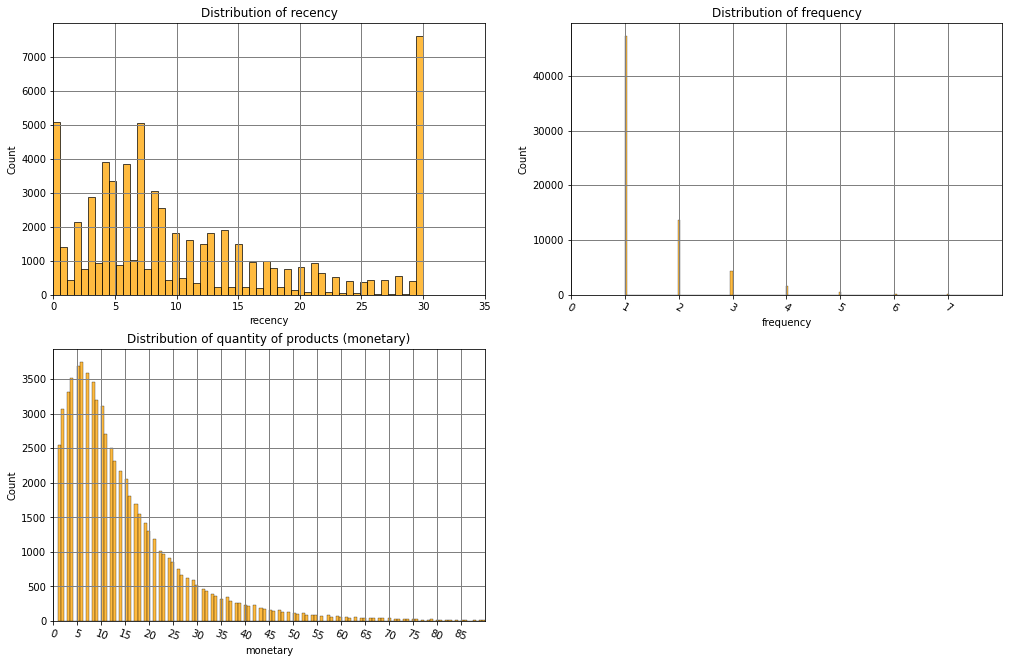

In [34]:
plt.figure(figsize=(17,11))
plt.subplot(2,2,1)
plt.title('Distribution of recency')
plt.xticks( np.arange(0, 100, 5), rotation=0 )
plt.xlim((0,35))
plt.grid(color='gray', linestyle='-', linewidth=1)
sns.histplot(df5['recency'], color='orange')

plt.subplot(2,2,2)
plt.title('Distribution of frequency')
plt.xticks( np.arange(0, 8, 1), rotation=-30 )
plt.xlim((0,8))
plt.grid(color='gray', linestyle='-', linewidth=1)
sns.histplot(df5['frequency'], color='orange')

plt.subplot(2,2,3)
plt.title('Distribution of quantity of products (monetary)')
plt.xticks( np.arange(0, 90, 5), rotation=-20 )
plt.xlim((0,90))
plt.grid(color='gray', linestyle='-', linewidth=1)
sns.histplot(df5['monetary'], color='orange')

# 6.0. Data Preparation

In [35]:
df6 = df5.copy()

## 6.1. Rescaling 

**Recency**

<AxesSubplot:>

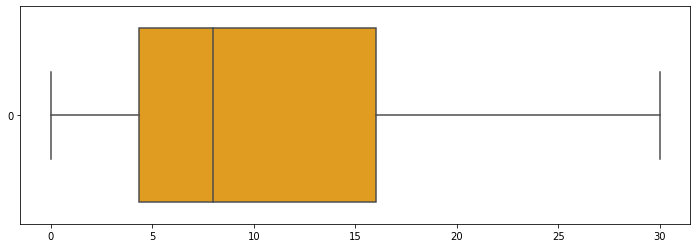

In [36]:
plt.figure(figsize=(12,4))
plt.grid(False)

sns.boxplot( data=df6['recency'], orient='h', color='orange')


We can notice in the box plot above that there aren't outliers, so we can use a Min-Max Scaler

In [37]:
mms = MinMaxScaler()
df6['recency'] = mms.fit_transform( df6[['recency']].values )

<AxesSubplot:>

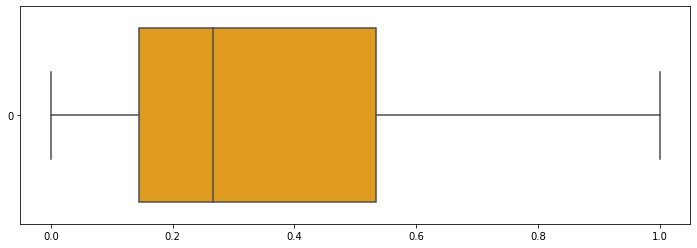

In [38]:
plt.figure(figsize=(12,4))
plt.grid(False)
sns.boxplot( data=df6['recency'], orient='h', color='orange' )

**Frequency**

<AxesSubplot:>

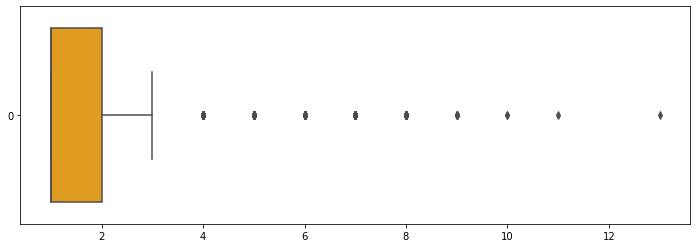

In [39]:
plt.figure(figsize=(12,4))
plt.grid(False)
sns.boxplot( data=df6['frequency'], orient='h', color='orange' )

In [40]:
rs = RobustScaler()
df6['frequency'] = rs.fit_transform( df6[['frequency']].values )

<AxesSubplot:>

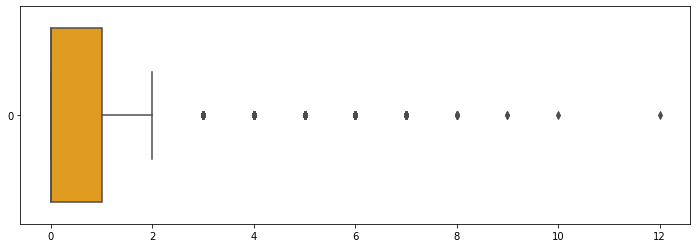

In [41]:
plt.figure(figsize=(12,4))
plt.grid(False)
sns.boxplot( data=df6['frequency'], orient='h', color='orange' )

**Monetary**

<AxesSubplot:>

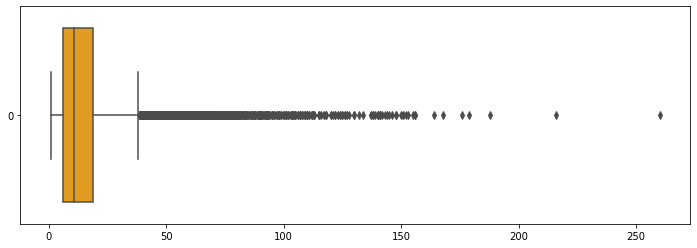

In [42]:
plt.figure(figsize=(12,4))
plt.grid(False)
sns.boxplot( data=df6['monetary'], orient='h', color='orange' )

In [43]:
rs = RobustScaler()
df6['monetary'] = rs.fit_transform( df6[['monetary']].values )

<AxesSubplot:>

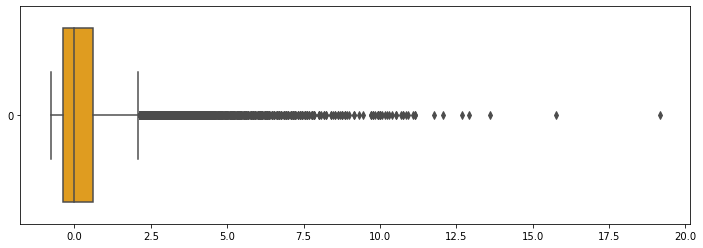

In [44]:
plt.figure(figsize=(12,4))
plt.grid(False)
sns.boxplot( data=df6['monetary'], orient='h', color='orange' )

## 6.2. Transformation

### 6.2.1. Encoding

### 6.2.2. Transformation of target variables

Applying logarithm transformation.

**Recency**

In [45]:
df6['recency'] = np.log1p( df6['recency'] )

**Frequency**

In [46]:
df6['frequency'] = np.log1p( df6['frequency'] )

**Monetary**

In [47]:
df6['monetary'] = np.log1p( df6['monetary'] )

# 7.0. Feature Selection

In [48]:
df7 = df6.copy()

As we are using RFM analysis, the only variables we are using are Recency, <br>
Frequency and Monetary, so we don't have to remove any other variable.

# 8.0. Machine Learning Model

In [49]:
df8 = df7.copy()

## KMEANS function

In [50]:
def kmeans_algorithm( k, df ):
    # runs the kmeans algorithm
    centroids, distortion = kmeans( df, k )

    # assign each data point to it's cluster
    cluster_labels, _ = vq(df, centroids)
    
    # create a new dataframe with a label column
    df_new = df.copy()
    df_new['label'] = cluster_labels
    df_new = df_new.reset_index().rename(columns={'index':'userID'})
    
    return df_new, cluster_labels

## Find the best number of clusters

In [51]:
distortions = []
silhouettes_avg = []
num_clusters = range(2,10)

# Calculates de distortion and average silhouette for several number of clusters
for i in num_clusters:
    
    # Run the kmeans algorithm
    centroids, distortion = kmeans( df8[['recency','frequency','monetary']], i )
    
    # assign each data point to it's respective cluster
    cluster_labels, _ = vq(df8[['recency','frequency','monetary']], centroids)

    # Data to the elbow plot
    distortions.append( distortion )
    
    # Calculates the average silhouette
    silhouette_avg = silhouette_score( df8[['recency','frequency','monetary']], cluster_labels )
    silhouettes_avg.append( silhouette_avg )

### Elbow Method

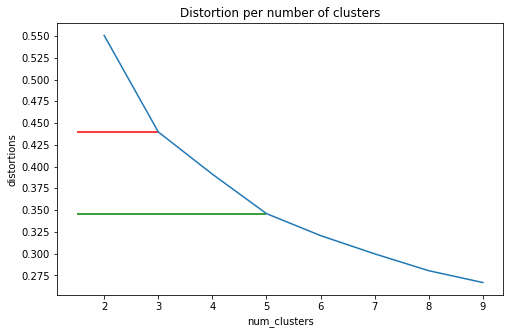

In [52]:
# plotting ELBOW
elbow_plot_data = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})
plt.figure(figsize=(8,5))
plt.xticks(np.arange(2,10,1))
plt.title('Distortion per number of clusters')
sns.lineplot(x='num_clusters', y='distortions', data=elbow_plot_data)
plt.yticks(np.arange(0.25, 0.55, 0.025))
plt.hlines(elbow_plot_data[elbow_plot_data['num_clusters'] == 3]['distortions'],1.5,3,color='red' )
plt.hlines(elbow_plot_data[elbow_plot_data['num_clusters'] == 5]['distortions'],1.5,5,color='green' )

### Silhouette Method

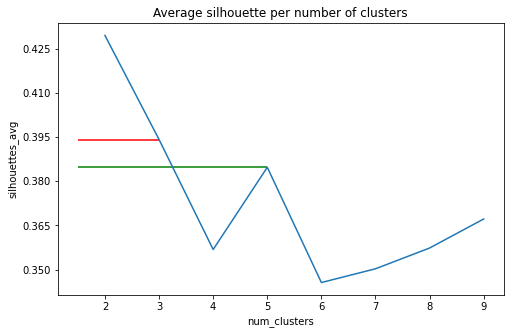

In [53]:
# SILHOUETTE average plot
silhouette_plot_data = pd.DataFrame({'num_clusters': num_clusters, 'silhouettes_avg': silhouettes_avg})
plt.figure(figsize=(8,5))
plt.xticks(np.arange(2,10,1))
plt.title('Average silhouette per number of clusters')
sns.lineplot(x='num_clusters', y='silhouettes_avg', data=silhouette_plot_data)
plt.yticks(np.arange(0.35, 0.44, 0.015))
plt.hlines(silhouette_plot_data[silhouette_plot_data['num_clusters'] == 3]['silhouettes_avg'],1.5,3,color='red' )
plt.hlines(silhouette_plot_data[silhouette_plot_data['num_clusters'] == 5]['silhouettes_avg'],1.5,5,color='green' )

## Running k-means for k = 3,4,5

In [54]:
df_k = []
for i in range(4):
    df_returned, _ = kmeans_algorithm(i+2, df8[['recency','frequency','monetary']])
    df_k.append( df_returned )

### TSNE PLOT

In [55]:
def tsne_plot( df ):
    # Initialize TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform( df )

    return transformed

### t-SNE plots for K = 2, 3, 4 and 5

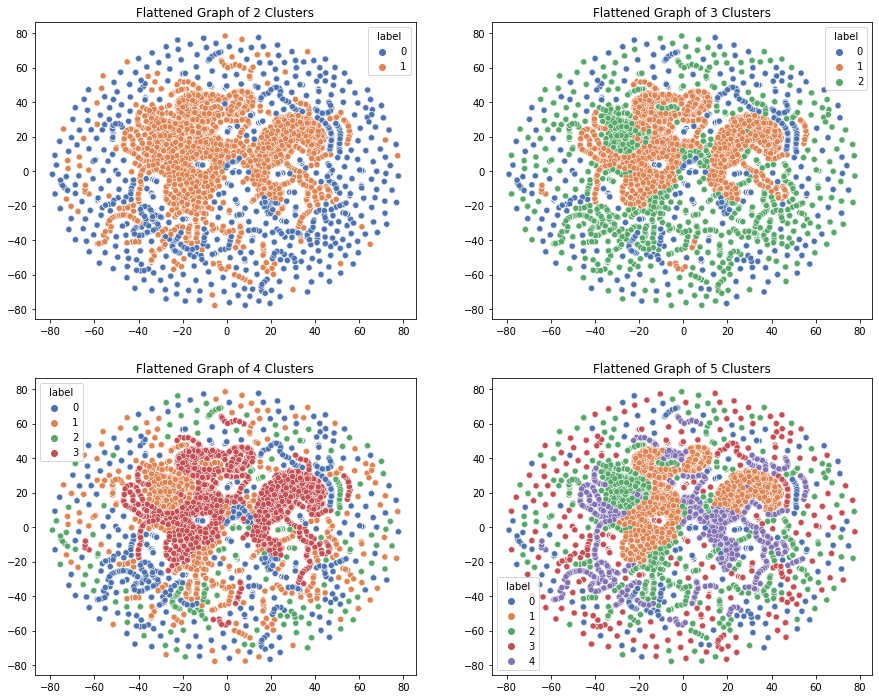

In [56]:
plt.figure(figsize=(15,12))
for i in range(4):
    df = df_k[i] 
    transformed = tsne_plot( df[['recency','frequency','monetary']] )
    # plot t-SNE 
    plt.subplot(2,2,i+1)
    plt.title('Flattened Graph of ' + str(i+2) + " Clusters")
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=df['label'], palette='deep')

### SNAKE PLOT

Melt the dataset - Recency, frequency and monetary will become values. Customer id and cluster labels will become IDs. 

In [57]:
def melt( df ):
    # melt the dataframe to create the snake plot
    df_melt = pd.melt( df, id_vars=['userID', 'label'], value_vars=['recency','frequency','monetary'], var_name=['Metric'], value_name='Value' ) 
    return df_melt

# Snake plots for K = 3, 4 and 5

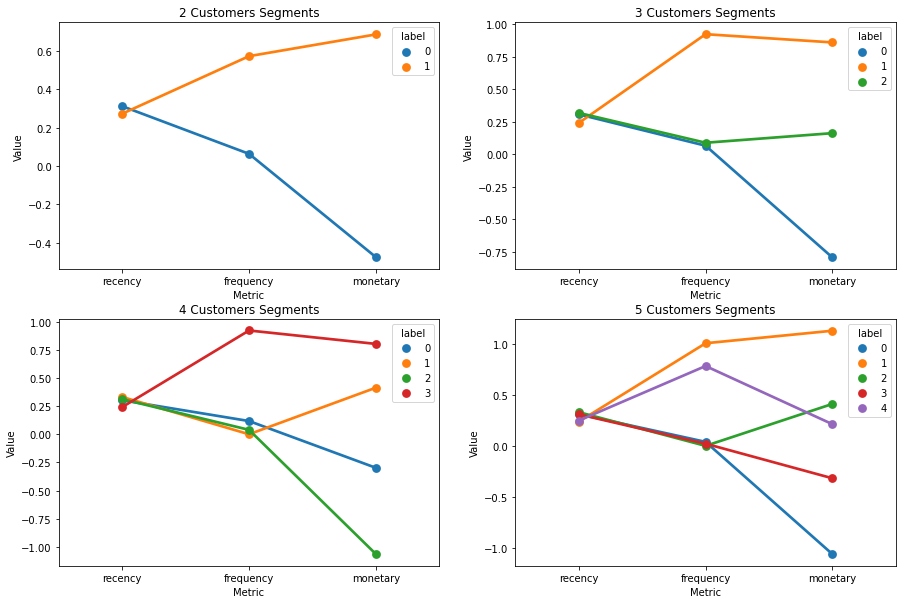

In [58]:
plt.figure(figsize=(15,10))
for i in range(4):
    df = df_k[i]
    df_melt = melt(df)

    # snake plot
    plt.subplot(2,2,i+1)
    plt.title(str(i+2) + ' Customers Segments')
    sns.pointplot(x='Metric', y='Value', hue='label', data=df_melt)

## Relative Importance

In [59]:
def relative_importance( df ):
    # Calculate the mean of each cluster
    clusters_mean = df[['recency','frequency','monetary','label']].groupby('label').mean()

    # Calculate the mean of population
    population_mean = df[['recency','frequency','monetary']].mean()
    
    # Calculate relative importance of each cluster to respect to the population
    relative_imp = clusters_mean / population_mean - 1
    
    return relative_imp 

### Generating relative importance for k = 3,4 and 5

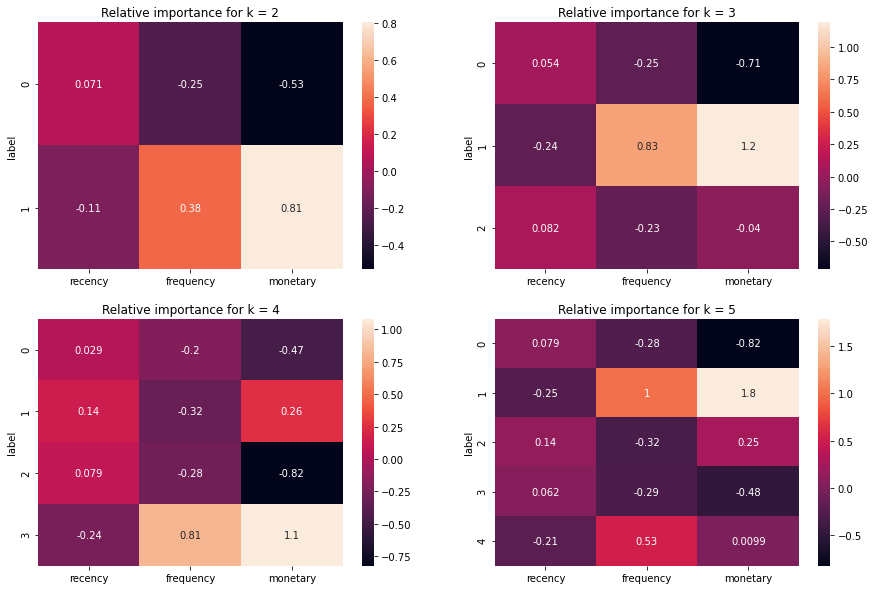

In [60]:
plt.figure(figsize=(15,10))
for i in range(4):
    # executes the clusterization
    df5['label'] = df_k[i]['label']
    # calculates relative importance
    relative_imp = relative_importance( df5 )
    # plot the chart of relative importance
    plt.subplot(2,2,i+1)
    plt.title('Relative importance for k = ' + str(i + 2))
    sns.heatmap(data=relative_imp, annot=True)

# 11.0. Results Interpretation

We are going to consider the kmeans with k = 5 as our model.

CLUSTER 4 - Rec: 5 , Freq: 5, Mon: 5, TOTAL = 15
            
CLUSTER 2 - Rec: 4, Freq: 4, Mon: 3, TOTAL = 11

CLUSTER 0 - Rec: 3, Freq: 2, Mon: 2, TOTAL = 7 

CLUSTER 1 - Rec: 1, Freq: 1, Mon: 4, TOTAL = 6 

CLUSTER 3 - Rec: 2, Freq: 3, Mon: 1, TOTAL = 6 


## INSIGHTS

### > CLUSTER 4 

- HIGHEST QUANTITY OF PRODUCTS BOUGHT.
- MOST FREQUENT one.

#### >> IDEAS

* Offer promotions.

* Loyalt campaign

* Try to increase cross sells by offering products that they don't buy yet.

### > CLUSTER 2 

- SECOND HIGHEST QUANTITY OF PRODUCTS BOUGHT.
- LESS FREQUENT ONE.

#### >> IDEAS

- Try to offer regular promotions, to improve their frequency.